# **Human In The Loop:**


**Human-in-the-Loop** (**HITL**) is an **agentic pattern** in LangGraph where a **human operator** is involved in the decision-making process or workflow execution of an LLM-powered agent. Instead of the system operating fully autonomously, humans can **intervene**, **validate**, or **modify** intermediate outputs to ensure accuracy, safety, or compliance. <br><br>


**Why Use the Human-in-the-Loop Pattern?**

1. **Ensuring Accuracy:** Humans validate intermediate steps to avoid errors or hallucinations in critical tasks.
2. **Handling Ambiguity:** When the model generates uncertain or ambiguous results, human input resolves these issues.
3. **Improving Safety:** Prevents incorrect or harmful decisions in high-stakes workflows (e.g., medical, legal).
4. **Feedback for Fine-Tuning:** Human oversight provides data to iteratively improve the system.
5. **Trust and Interpretability:** Including humans in the loop builds trust in AI outputs by adding a layer of oversight.

<br> <br>


**How HITL Works in LangGraph:**

1. **Trigger Point:** A specific node in the workflow signals the need for human intervention (e.g., when confidence in model output is low).
2. **Human Oversight:** The human operator reviews the output and either approves it or makes corrections.
3. **Continuation:** Once validated, the workflow resumes and completes the task.

<br><br>


**When to Use HITL?**

* Tasks with **high stakes** (e.g., legal, medical, or financial decisions).
* **Ambiguous queries** where LLM confidence is low.
* **Fine-tuning and debugging** workflows during development.
* Situations requiring **ethical or contextual judgment**.

<br><br>


**Example: HITL for Legal Document Review.** <br>
**Scenario:** A legal assistant agent reviews contracts to flag compliance issues. <br>

1. **WorkFlow:**
    * **Node 1:** LLM analyzes the contract for risky clauses.
    * **Node 2:** Human reviews flagged clauses for accuracy.
    * **Node 3:** LLM generates recommendations based on the validated input.

2. **HITL Trigger:**
    * If the agent flags a clause as "ambiguous" or "high risk," it requires human confirmation before proceeding.

3. **Human Role:**
    * Validates flagged clauses and provides feedback to refine future performance.

4. **Outcome:**
    * Ensures only accurate and validated recommendations are sent to legal teams.


<br><br>

The **Human-in-the-Loop** (**HITL**) pattern in LangGraph ensures workflows are accurate, adaptable, and safe by involving human operators at critical decision points. It combines the scalability of automation with the reliability of human judgment, making it a powerful pattern for real-world, high-stakes applications.




In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()


GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

## **Load LLM:**

In [2]:
from langchain_groq import ChatGroq

llm = ChatGroq(model_name="Gemma2-9b-It")
llm.invoke("Hi").content

'Hi! 👋\n\nWhat can I do for you today? 😊\n'

In [ ]:
from typing import Annotated
import operator, json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

## **Custom Logic Approach:**

### **Create or Define Tools:**

In [5]:
# Custom Tool:

@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    
    return first_number * second_number

multiply({"first_number":24,"second_number":10})

240

In [ ]:
# Another Tool, make it custom:

@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    
    return result

In [8]:
# Toolkits:

tools = [search, multiply]
tools

[StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000022917EBA290>),
 StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x00000229191088B0>)]

In [9]:
tool_mapping = {tool.name: tool for tool in tools}
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000022917EBA290>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x00000229191088B0>)}

### **Bind Tool with LLM:**

In [10]:
# bind tool with llm:

llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000022917D0CE50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000022917D0E200>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'search', 'description': 'perform the web search on the user query', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'multiply two integer number', 'parameters': {'properties': {'first_number': {'type': 'integer'}, 'second_number': {'type': 'integer'}}, 'required': ['first_number', 'second_number'], 'type': 'object'}}}]}, config={}, config_factories=[])

### **Insites from Tool Calling with llm:**

In [11]:
response = llm_with_tools.invoke("who is a current president of USA?")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kj9n', 'function': {'arguments': '{"query":"who is the current president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1076, 'total_tokens': 1162, 'completion_time': 0.156363636, 'prompt_time': 0.061370917, 'queue_time': 0.020640304999999998, 'total_time': 0.217734553}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-af2e54de-a8ae-40ab-9b65-173fd0f64d97-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is the current president of USA'}, 'id': 'call_kj9n', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1076, 'output_tokens': 86, 'total_tokens': 1162})

In [24]:
# Check Which Tool is Calling:

tool_details = response.additional_kwargs.get("tool_calls")
tool_details

[{'id': 'call_kj9n',
  'function': {'arguments': '{"query":"who is the current president of USA"}',
   'name': 'search'},
  'type': 'function'}]

In [ ]:
# Get the Tool Name:

tool_details[0]["function"]["name"]

'search'

In [17]:
# Get the Query that user asking:


tool_details[0]["function"]["arguments"]

'{"query":"who is the current president of USA"}'

In [ ]:
# Invoke the tool (which is binded with llm):

tool_mapping[tool_details[0]["function"]["name"]].invoke(json.loads(tool_details[0]["function"]["arguments"]))

[{'url': 'https://www.usa.gov/presidents',
  'content': 'Presidents, vice presidents, and first ladies | USAGov An official website of the United States government A .gov website belongs to an official government organization in the United States. Learn about the duties of president, vice president, and first lady of the United States. President of the United States The president of the United States is the: Former U.S. presidents The United States has had 46 former U.S. presidents. Vice president of the United States The vice president of the United States presides over the U.S. Senate and takes over the role of president of the United States if the president is unable to perform their duties. The 50th and current vice president of the United States is James David (JD) Vance.'},
 {'url': 'https://www.whitehouse.gov/',
  'content': 'The White House Administration The White House President Donald J. Trump Search Administration Search for:  Press Enter to Search America Is Back This will

### **LangGraph Integration:**

#### **Create Nodes:**

In [25]:
# Define the Basic Structured Output:


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [31]:
# Create Node: Invoke Model:

def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user latest question

    return {"messages":[llm_with_tools.invoke(question)]}

In [27]:
# Conditional Flow, i.e., Human in Loop

def invoke_tool(state:AgentState):
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]

    if tool_details is None:
        # raise Exception("no tool call found")
        return "no tool call found"

    print(f'Selected tool: {tool_details.get("function").get("name")}')

    if tool_details.get("function").get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            # raise Exception("web search discard")
            return "web search discard"

    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}

In [29]:
# Router:

def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    
    if len(tool_calls):
        return "tool"
    
    else:
        return "end"

#### **Create Graph:**

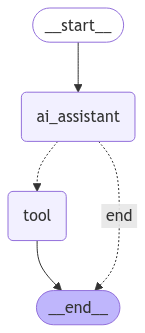

In [35]:
### StateGraph with AgentState
graph = StateGraph(AgentState)

# Add Nodes:
graph.add_node("ai_assistant", invoke_model)
graph.add_node("tool", invoke_tool)

# Define Conditional FLow:
graph.add_conditional_edges(
    "ai_assistant",
    router,
    {
        "tool": "tool",
        "end": END
    }
)

# Add Edge Flow:
graph.add_edge("tool", END)


# graph.add_edge("tool", "ai_assistant")


# Set Entry Point:
graph.set_entry_point("ai_assistant")


app = graph.compile()

app

#### **Invoking:**

In [37]:
response = app.invoke({"messages": ["who is upcoming president of USA?"]})
response

Selected tool: search


{'messages': ['who is upcoming president of USA?',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_s08z', 'function': {'arguments': '{"query":"upcoming president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 1075, 'total_tokens': 1158, 'completion_time': 0.150909091, 'prompt_time': 0.046343157, 'queue_time': 0.016361407, 'total_time': 0.197252248}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-922a5f9c-9739-47ee-8c74-7686f9f8c1f4-0', tool_calls=[{'name': 'search', 'args': {'query': 'upcoming president of USA'}, 'id': 'call_s08z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1075, 'output_tokens': 83, 'total_tokens': 1158}),
  [{'url': 'https://www.britannica.com/event/United-States-presidential-election-of-2024',
    'content': 'United States presidential election of 2024 | Background, Candi

In [38]:
for s in app.stream({"messages": ["what is multiplication of 23 and 46?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_p1xa', 'function': {'arguments': '{"first_number":23,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 1080, 'total_tokens': 1173, 'completion_time': 0.169090909, 'prompt_time': 0.037743008, 'queue_time': 0.019340167999999998, 'total_time': 0.206833917}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f9a10566-464d-4ce5-a579-6506c313fba4-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 23, 'second_number': 46}, 'id': 'call_p1xa', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1080, 'output_tokens': 93, 'total_tokens': 1173})]}
----
Selected tool: multiply
{'messages': [1058]}
----


In [40]:
for s in app.stream({"messages": ["what is the total amount of money exist over the earth?"]}):
    print(list(s.values())[0])
    print("----")

# Select no

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_e3c7', 'function': {'arguments': '{"query":"what is the total amount of money exist over the earth"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 1080, 'total_tokens': 1170, 'completion_time': 0.163636364, 'prompt_time': 0.046446627, 'queue_time': 0.019508005000000002, 'total_time': 0.210082991}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ba5f5265-eee0-4918-aefc-d352ffa9b103-0', tool_calls=[{'name': 'search', 'args': {'query': 'what is the total amount of money exist over the earth'}, 'id': 'call_e3c7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1080, 'output_tokens': 90, 'total_tokens': 1170})]}
----
Selected tool: search


InvalidUpdateError: Expected dict, got web search discard
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE

## **In-Build Logic of LangGraph:**

In [41]:
from typing import Annotated
import operator, json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

### **Define or Create Custom Tool:**

In [42]:
# Custom Tool:

@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

multiply({"first_number":24,"second_number":10})

240

In [43]:
# Another Tool, make it custom:

@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()

    result=tavily.invoke(query)
    
    return result

In [44]:
# Toolkits:

tools = [search, multiply]

### **Bind Tool with LLM:**

In [45]:
# bind tool with llm:

llm_with_tools = llm.bind_tools(tools)

### **Create Node:**

In [46]:
# Define Structure Format:


class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

In [47]:
# Define a Node, called ai_assistant:


def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [48]:
# Create Tool Node:

tool_node = ToolNode(tools=tools)

### **Define Memory:**

In [50]:
# memory:

memory = MemorySaver()
memory

### **LangGraph Integration:**

In [51]:
from langgraph.prebuilt import ToolNode, tools_condition

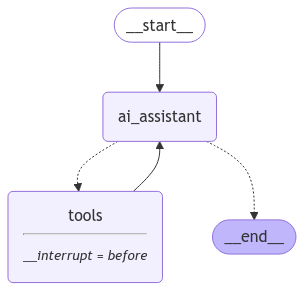

In [52]:
# Define StateGraph:
graph_builder = StateGraph(AgentState)

# Add Node into Graph:
graph_builder.add_node("ai_assistant", ai_assistant)
graph_builder.add_node("tools", tool_node)

# Add Edge Flow:
graph_builder.add_edge(START, "ai_assistant")

# Add Conditional Flow:
graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition,
)

# Add Edges:
graph_builder.add_edge("tools", "ai_assistant")

# Compile Graph: Using 'interrupt_before'
app2 = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)


app2

#### **Invoking (not use tool):**

In [53]:
user_input = "what is current a capital of india?"
config = {"configurable": {"thread_id": "1"}}

# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is current a capital of india?
================================== Ai Message ==================================
Tool Calls:
  search (call_mpvj)
 Call ID: call_mpvj
  Args:
    query: what is the capital of india


#### **Invoking (use tool):**

- by mention `None`

In [57]:
user_input = "what is current a capital of india?"
config = {"configurable": {"thread_id": "1"}}

# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search (call_cacs)
 Call ID: call_cacs
  Args:
    query: what is the capital of india
================================= Tool Message =================================
Name: search

[{"url": "https://www.usatoday.com/story/news/world/2023/05/24/what-is-the-capital-of-india/70195720007/", "content": "About 1.4 billion people live in India, and the country is predicted to top China as the world’s most populous country by mid-2023, the United Nations reports. The capital of India is New Delhi, located in the north-central part of the country to the west of the Yamuna River. India is home to 28 states, each with its own capital and run by a Governor who represents the President: New Delhi is part of one of India’s union territories, the National Capital Territory of Dehli. 10Best USAT Wine Club Shopping Best-selling Booklist Southern Kitchen Jobs Sports Betting Sports Weekly Studio Gannett Classi

In [ ]:
# Second:

user_input = "what is a weather there?"
config = {"configurable": {"thread_id": "1"}}

events = app2.stream(input={"messages": [("user", user_input)]}, config=config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather there?
================================== Ai Message ==================================
Tool Calls:
  search (call_6qhg)
 Call ID: call_6qhg
  Args:
    query: weather in New Delhi


In [59]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search (call_6qhg)
 Call ID: call_6qhg
  Args:
    query: weather in New Delhi
================================= Tool Message =================================
Name: search

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'New Delhi', 'region': 'Delhi', 'country': 'India', 'lat': 28.6, 'lon': 77.2, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1740831786, 'localtime': '2025-03-01 17:53'}, 'current': {'last_updated_epoch': 1740831300, 'last_updated': '2025-03-01 17:45', 'temp_c': 25.2, 'temp_f': 77.4, 'is_day': 1, 'condition': {'text': 'Mist', 'icon': '//cdn.weatherapi.com/weather/64x64/day/143.png', 'code': 1030}, 'wind_mph': 2.2, 'wind_kph': 3.6, 'wind_degree': 357, 'wind_dir': 'N', 'pressure_mb': 1012.0, 'pressure_in': 29.88, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 54, 'cloud': 50, 'feelslike_c': 25.3, 'feelslike_f': 77.6, 'windchill_c': 26.1, 'windchill_f': 

**Note:** Custom Logic suitable for application building.